<a href="https://colab.research.google.com/github/IAMPathak2702/Intel_image_classification/blob/main/Intel_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing relevant Libraires

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import keras
from keras.applications import ResNet50
import os
import random
import matplotlib.image as mpimg

In [2]:
from keras.layers import Dense , Flatten

# Import Data

In [3]:

!chmod 600 /content/kaggle.json
os.environ["KAGGLE_CONFIG_DIR"] = '/content'
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 339M/346M [00:02<00:00, 149MB/s]
100% 346M/346M [00:02<00:00, 130MB/s]


In [4]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [5]:
for dirpath, dirnames, filenames in os.walk("/content/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 5 directories and 2 images in '/content/'.
There are 2 directories and 7 images in '/content/.config'.
There are 1 directories and 0 images in '/content/.config/logs'.
There are 0 directories and 6 images in '/content/.config/logs/2024.03.26'.
There are 0 directories and 1 images in '/content/.config/configurations'.
There are 1 directories and 0 images in '/content/seg_test'.
There are 6 directories and 0 images in '/content/seg_test/seg_test'.
There are 0 directories and 501 images in '/content/seg_test/seg_test/street'.
There are 0 directories and 553 images in '/content/seg_test/seg_test/glacier'.
There are 0 directories and 474 images in '/content/seg_test/seg_test/forest'.
There are 0 directories and 437 images in '/content/seg_test/seg_test/buildings'.
There are 0 directories and 525 images in '/content/seg_test/seg_test/mountain'.
There are 0 directories and 510 images in '/content/seg_test/seg_test/sea'.
There are 1 directories and 0 images in '/content/seg_pred'.
Th

# Define DataPath and Prepare dataset

In [6]:
train_dir = "/content/seg_train/seg_train/"
val_dir = "/content/seg_test/seg_test/"

In [7]:
train_data = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode = "categorical",
    image_size = (224,224),
    seed = 42,
)

val_data = keras.utils.image_dataset_from_directory(
    directory=val_dir,
    label_mode = "categorical",
    image_size = (224,224),
    seed = 42,

)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## Class Names

In [8]:
class_names =train_data.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Prefetch

In [9]:
train_ds = train_data.prefetch(tf.data.AUTOTUNE)
val_ds = val_data.prefetch(tf.data.AUTOTUNE)

# Taking a Deeper look at the Data

In [10]:
def view_random_image(target_dir,class_names):
    # Setup target directory (we'll view images from here)

    plt.figure(figsize = (20,14))
    for i in range(0,12):
        target_class = random.choice(list(class_names))
        target_folder = target_dir+target_class
        # Get a random image path
        random_image = random.sample(os.listdir(target_folder), 1)
        # Read in the image and plot it using matplotlib

        img = mpimg.imread(target_folder + "/" + random_image[0])
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img)
        plt.title(f"{target_class}--{img.shape}")
        plt.axis("off");
    return img


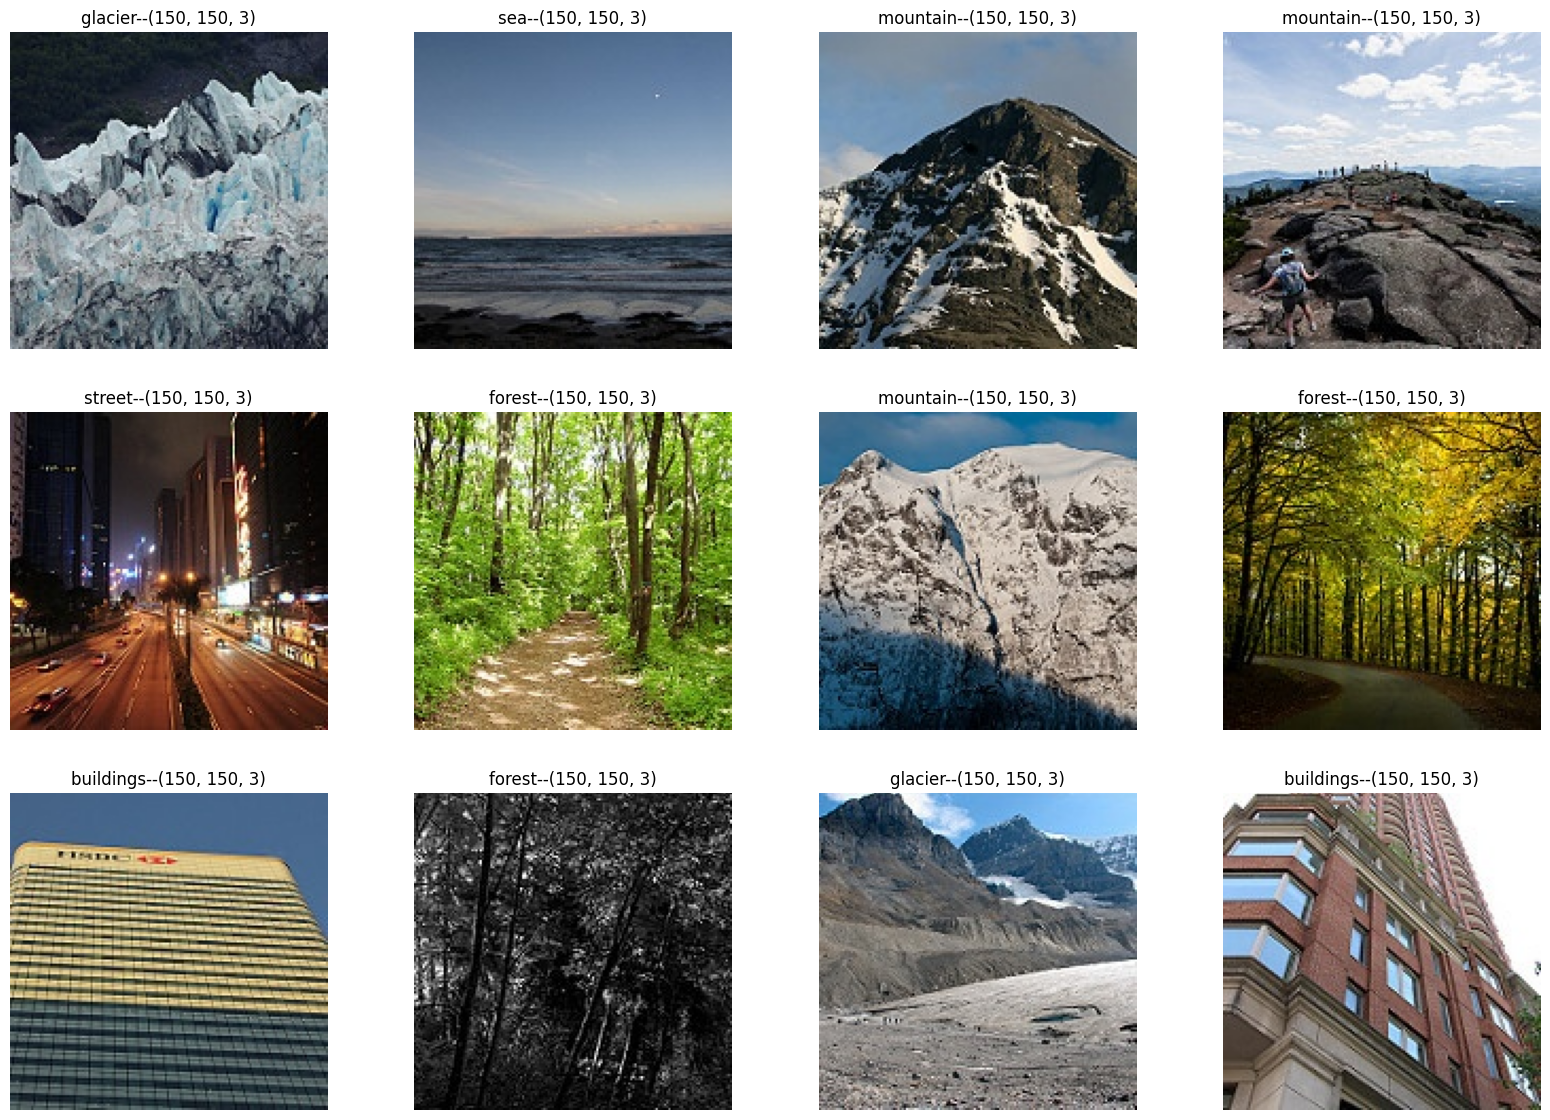

In [11]:
img = view_random_image(target_dir=train_dir,
                        class_names = class_names)

# Defining Checkpoints

In [12]:
def model_checkpoint_callback(filepath):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'/content/{filepath}',  # Specify the path to save the best model
        monitor='val_accuracy',   # Choose a metric to monitor (e.g., validation accuracy)
        save_best_only=True,       # Save only the best model
        save_weights_only=False,   # Set to True if you want to save only model weights
        mode='max',               # Set to 'max' for accuracy, 'min' for loss, or 'auto'
        verbose=0,               # Optional: Set to 1 for progress messages
    )
    return model_checkpoint_callback



early_stopping = keras.callbacks.EarlyStopping(
                                                monitor='val_loss',   # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
                                                patience=3,           # Number of epochs with no improvement before stopping
                                                restore_best_weights=True  # Restore model weights from the best epoch
                                            )


# Define Model


In [13]:
resnet = ResNet50(input_shape = (224,224,3) , include_top = False)
for layer in resnet.layers:
    layer.trainable = False


x = Flatten()(resnet.output)
o = Dense(len(class_names), activation="softmax", name="output_layer")(x)

model_1 = keras.Model(resnet.input ,o, name = "RESNET_MODEL")
model_1.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "RESNET_MODEL"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                  

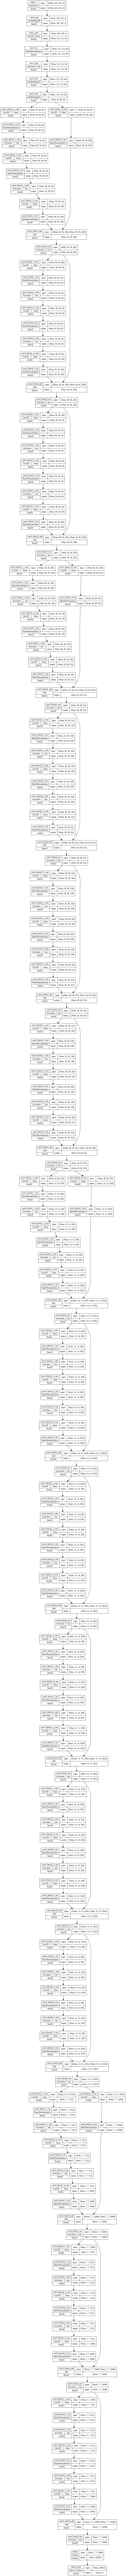

In [14]:
from keras.utils import plot_model
plot_model(model_1, show_shapes=True , show_dtype=True , show_layer_activations=True)

## Compile the model

In [15]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


# Fitting the Data and Training the model

In [16]:
hist_1 = model_1.fit(train_ds,
                        epochs = 10,
                        steps_per_epoch = len(train_ds),
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = [model_checkpoint_callback('MOdel_RESNET50'),early_stopping])


Epoch 1/10
439/439 [==============================] - 102s 216ms/step - loss: 3.3058 - accuracy: 0.8672 - val_loss: 3.2897 - val_accuracy: 0.8837
Epoch 2/10
439/439 [==============================] - 94s 213ms/step - loss: 1.2684 - accuracy: 0.9468 - val_loss: 3.8814 - val_accuracy: 0.8917
Epoch 3/10
439/439 [==============================] - 81s 184ms/step - loss: 0.6782 - accuracy: 0.9679 - val_loss: 4.5751 - val_accuracy: 0.8913
Epoch 4/10
439/439 [==============================] - 98s 224ms/step - loss: 0.5512 - accuracy: 0.9764 - val_loss: 4.7817 - val_accuracy: 0.9000


# Tracking model Progress

In [17]:
import matplotlib.pyplot as plt

def plot_hist_graph(history):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title("Epoch vs Accuracy")

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.subplot(1, 3, 2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

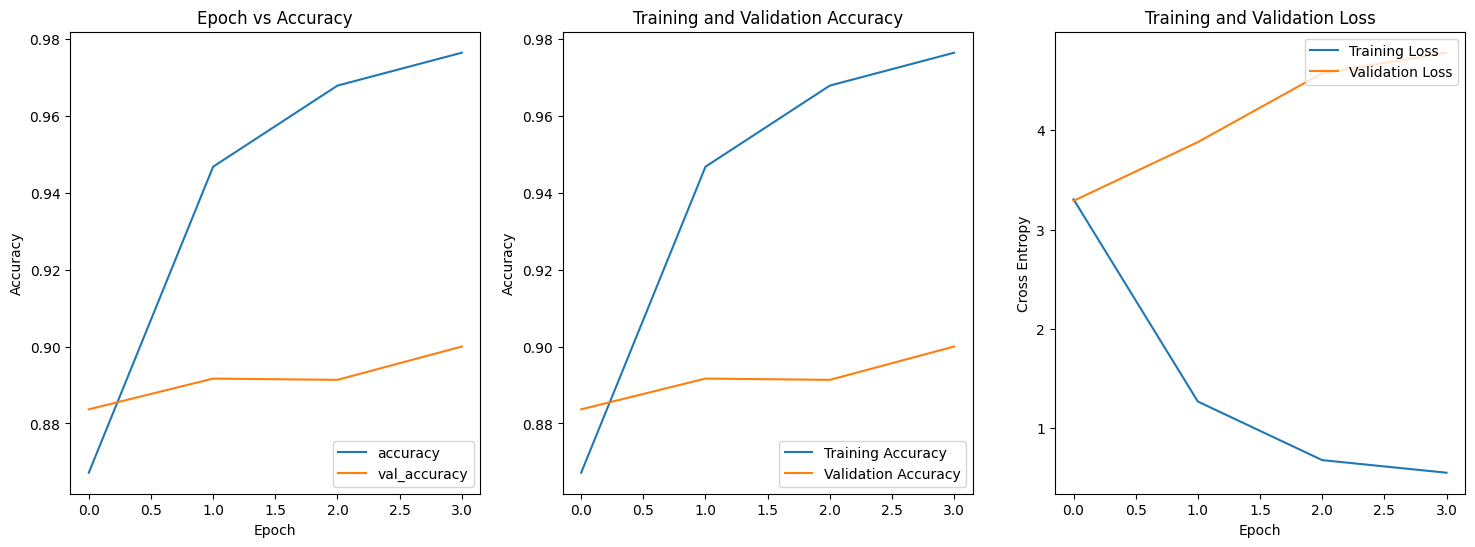

In [18]:
plot_hist_graph(hist_1)

In [19]:
!zip MOdel_RESNET50.zip /content/MOdel_RESNET50 -r

  adding: content/MOdel_RESNET50/ (stored 0%)
  adding: content/MOdel_RESNET50/variables/ (stored 0%)
  adding: content/MOdel_RESNET50/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/MOdel_RESNET50/variables/variables.index (deflated 81%)
  adding: content/MOdel_RESNET50/saved_model.pb (deflated 92%)
  adding: content/MOdel_RESNET50/assets/ (stored 0%)
  adding: content/MOdel_RESNET50/keras_metadata.pb (deflated 96%)
  adding: content/MOdel_RESNET50/fingerprint.pb (stored 0%)


# Evaluating the Model